# Physics 231: Final Project
# Quantum Adiabatic Evolution vs QAOA: Anharmonic Oscillator

____________

## Setup

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#### We will be setting $\hbar = m = \omega = 1$ .

In [2]:
# IN SI UNITS
# const_hbar = 1.0545718 * 1e-34
# const_omega = 1e+16
# const_mass = 9.10938356 * 1e-31

const_hbar = 1
const_omega = 1
const_mass = 1

### Defining the Ladder Operators in the Harmonic Oscillator Basis

__Note:__ n sets the size of the Hilbert Space spanned by the basis states $\{|0\rangle,|1\rangle,...,|n-1\rangle\}$.

In [3]:
def op_a(n):
    mat = np.zeros((n, n))
    for i in range(n-1):
        mat[i][i+1] = np.sqrt(i+1)
    return mat

def op_adag(n):
    mat = np.zeros((n, n))
    for i in range(n-1):
        mat[i+1][i] = np.sqrt(i+1)
    return mat

def op_n(n):
    a = op_a(n)
    adag = op_adag(n)
    mat = np.dot(adag,a)
    return mat

In [4]:
a = op_a(5)
b = op_adag(5)
print(np.dot(a,b)-np.dot(b,a)) #expect [a,adag] = 1
print(op_n(5))

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -4.]]
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 4.]]


__Note:__ The error in the last row is a result of the fact that the originally infinite Hilbert Space has been truncated.

### Defining the x,p in terms of Dagger Operators

$$x = \sqrt{\frac{\hbar}{2m\omega}}(a+a^+)$$

$$p = -i\sqrt{\frac{m\omega\hbar}{2}}(a-a^+)$$

In [5]:
def op_x(n):
    mat = np.sqrt(const_hbar/(2*const_mass*const_omega))*(op_a(n) + op_adag(n))
    return mat

def op_p(n):
    mat = (-1j)*np.sqrt((const_hbar*const_mass*const_omega)/2)*(op_a(n) - op_adag(n))
    return mat

In [6]:
x = op_x(5)
p = op_p(5)
print(np.imag(np.dot(x,p)-np.dot(p,x))) # expect [x,p] = ihbar

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -4.]]


#### Test: Is $x^2$ the same from definition of x and dagger operators

In [7]:
# FROM DAGGER OPERATORS
a = op_a(5)
adag = op_adag(5)
# x2 = 0.5*((np.dot(a,a)+np.dot(adag,adag)+np.eye(5)+2*op_n(5))) # using aa^+ = 1 + n
x2 = 0.5*((np.dot(a,a)+np.dot(adag,adag)+np.dot(adag,a)+np.dot(a,adag)))
x2

array([[0.5       , 0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 1.5       , 0.        , 1.22474487, 0.        ],
       [0.70710678, 0.        , 2.5       , 0.        , 1.73205081],
       [0.        , 1.22474487, 0.        , 3.5       , 0.        ],
       [0.        , 0.        , 1.73205081, 0.        , 2.        ]])

In [8]:
# FROM DEFINITION OF x
x = op_x(5)
x2_test = np.dot(x,x)
x2_test

array([[0.5       , 0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 1.5       , 0.        , 1.22474487, 0.        ],
       [0.70710678, 0.        , 2.5       , 0.        , 1.73205081],
       [0.        , 1.22474487, 0.        , 3.5       , 0.        ],
       [0.        , 0.        , 1.73205081, 0.        , 2.        ]])

__Result:__ Both are same, as expected. Life is good.

In [9]:
def op_x2(n):
    x = op_x(n)
    mat = np.dot(x,x)
    return mat

def op_p2(n):
    p = op_p(n)
    mat = np.dot(p,p)
    return mat

def op_x3(n):
    x = op_x(n)
    x2 = op_x2(n)
    mat = np.dot(x,x2)
    return mat

def op_x4(n):
    x2 = op_x2(n)
    mat = np.dot(x2,x2)
    return mat

### Defining the Hamiltonians in terms of Dagger Operators

$$H_i = \frac{p^2}{2m} + \frac{m\omega^2 x^2}{2}$$

$$H_f = \frac{p^2}{2m} + \frac{m\omega^2(x-b)^2}{2} + \lambda (x-b)^4 $$

In [10]:
def op_Hi(n):
    x2 = op_x2(n)
    p2 = op_p2(n)
    mat = 0.5*(const_mass*const_omega**2*x2 + p2/const_mass) 
    return mat
    
def op_Hf(n, b, lam):
    b = b*np.eye(n)
    x = op_x(n)
    x2 = np.dot(x-b,x-b)
    x4 = np.dot(x2,x2)
    p2 = op_p2(n)
    mat = 0.5*(const_mass*const_omega**2*x2 + p2/const_mass) + lam*x4
    return mat 

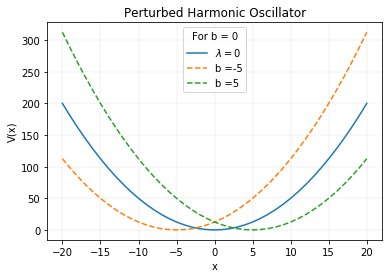

In [145]:
lam = 0
b_arr = [-5,5]
x_arr = np.array(range(-20,21))

y_arr = (x_arr)**2/2
plt.plot(x_arr, y_arr, label = r'$\lambda = 0$')

for b in b_arr:
    y_arr = (x_arr - b)**2/2 + lam*(x_arr - b)**4
    plt.plot(x_arr, y_arr, '--', label = 'b =' + str(b))

plt.grid(color='grey', linestyle='-', linewidth=0.1)
plt.legend(title = 'For b = 0', loc = 'upper center')
plt.title('Perturbed Harmonic Oscillator')
plt.xlabel('x')
plt.ylabel('V(x)')
#plt.savefig(fname = "pot_b.png", dpi = 300)

In [72]:
x_arr = np.array(range(-15,15))
x_arr - 5

array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
        -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9])

### Defining the n-th state of SHO

In [11]:
def state_n(dim, n):
    vec = np.zeros(dim)
    vec[n] = 1
    return vec

_____________________

## Quantum Adiabatic Evolution

We want to evolve the system from the initial $H_i$ to the final $H_f$ using the Adiabatic Theorem such that:

$$ H(t, T, \lambda, b) = H_i \Big(1 - \frac{t}{T}\Big) + H_f(\lambda, b) \frac{t}{T} $$

where $t \in [0,T]$.

To do so, we will time evolve the ground state $|0\rangle$ of the SHO using the time dependent Hamiltonian above. 

In [24]:
def run_QAC(dim, b, lam, T_i, T_f, num_T):

    probs = []
    num_steps = 100 # M
    T_ar = np.linspace(T_i, T_f, num_T)
    
    psi_i = state_n(dim, 0)
    e, v = np.linalg.eig(op_Hf(dim, b, lam))
    psi_f = v[:, np.argmin(e)]

    for T in T_ar:
        # print('At T:', T)
        U = np.eye(dim)
        step = T/(num_steps + 1)

        for m in range(num_steps + 1):
            U_m = expm(-1j*((1-m/num_steps)*op_Hi(dim) + (m/num_steps)*op_Hf(dim, b, lam))*step) 
            U = np.matmul(U_m,U)

        psi = np.dot(U,psi_i)
        psi = psi/np.linalg.norm(psi)
        prob = np.linalg.norm(np.dot(np.conjugate(psi),psi_f))**2.0
        probs.append(prob)
        
    return T_ar, probs

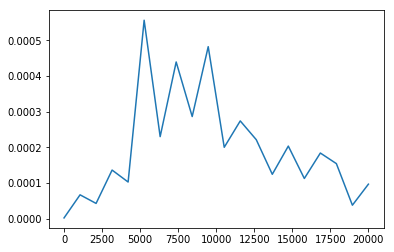

In [39]:
dim = 11
b = 0
lam = -5
T_i = 0
T_f = 20000
num_T = 20

T_ar, probs = run_QAC(dim, b, lam, T_i, T_f, num_T)
    
plt.plot(T_ar, probs)
plt.show()

Wall time: 1min 45s


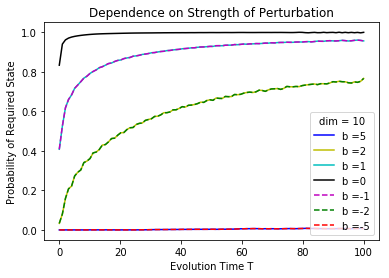

In [285]:
%%time

dim = 10
# b = 0
lam = 5
T_i = 0
T_f = 100
num_T = 100

colors = ['b','y','c','k','m','g','r']

sweep = list(np.linspace(-1, 100, 5))
for i, value in enumerate([5, 2, 1, 0, -1, -2, -5]):
    T_ar, probs = run_QAC(dim, value, lam, T_i, T_f, num_T)
    if value >= 0:
        plt.plot(T_ar, probs, label = 'b =' + str(round(value,1)), alpha = 1, color = colors[i])
    if value < 0:
        plt.plot(T_ar, probs, '--',label = 'b =' + str(round(value,1)), alpha = 1, color = colors[i])
    # plt.plot(T_ar, probs, label = r'$\lambda =$' + str(round(value,1)), alpha = 1)

plt.xlabel('Evolution Time T')
plt.ylabel('Probability of Required State')
plt.title('Dependence on Strength of Perturbation')
plt.legend(title = 'dim = 10')
#plt.savefig(fname = "b.png", dpi = 300)

### Checking the energy gap

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


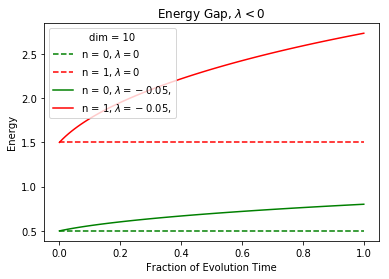

In [65]:
dim = 11
b = 0
lam = 1
T = 1
num_steps = 100
e0 = []
e1 = []
    
time = np.linspace(0,T,num_steps)
for t in time:
    H_t = op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T)
    eigval, eigvec  = np.linalg.eig(H_t)
    eigval = np.sort(eigval)
    e0.append(eigval[0])
    e1.append(eigval[1])

plt.plot(time, [0.5]*len(time), '--g', label = 'n = 0, ' + r'$\lambda = 0$', alpha = 1)
plt.plot(time, [1.5]*len(time), '--r', label = 'n = 1, ' + r'$\lambda = 0$')
plt.plot(time, e0, color = 'g', label = 'n = 0, ' + r'$\lambda = -0.05,$')
plt.plot(time, e1, color = 'r', label = 'n = 1, ' + r'$\lambda = -0.05,$')
plt.xlabel('Fraction of Evolution Time')
plt.ylabel('Energy')
plt.title('Energy Gap, ' + r'$\lambda < 0$')
plt.legend(title = 'dim = 10')
#plt.xlim(0.9,1)
#plt.ylim(0.2,0.4)
#plt.yscale('log')
#plt.savefig(fname = "egap_neg_zoom_.png", dpi = 300)
plt.show()

_____________________

## QAOA

### Defining the Ansatz

$$ |\psi_p \rangle = \prod_{k=1}^{p} e^{-i \beta_k H_i} e^{- i \gamma_k H_f} |\psi_0 \rangle$$

In [59]:
def ansatz(dim, b, lam, params):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    mat = np.array(np.eye(dim))
    for i in range(len(betas)):
        mat = np.matmul(expm(-1j*gammas[i]*op_Hf(dim, b, lam)), mat)
        mat = np.matmul(expm(-1j*betas[i]*op_Hi(dim)), mat)
    return mat

In [60]:
def cost(params, flag = 0):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    state = np.matmul(ansatz(dim, b, lam, params), psi_i)
    if flag:
        return np.linalg.norm(np.dot(np.conjugate(psi_f), state))**2.0
    hamil_state = np.matmul(op_Hf(dim, b, lam), state)
    expectation = np.dot(np.conjugate(state), hamil_state)
    #print(expectation, np.linalg.norm(state), np.linalg.norm(hamil_state))
    #print(expectation)
    return np.linalg.norm(expectation)    

In [61]:
def run_QAOA(p_max):
    p_arr = list(range(1,p_max+1))
    probs = []
    for p in p_arr:
        print('At p:',p)
        params = [0.5] * 2 * p
        x = minimize(cost, params)
        probs.append(cost(x['x'], 1))
    return p_arr, probs

At p: 1
At p: 2
At p: 3
At p: 4
At p: 5


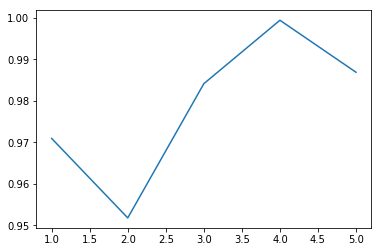

In [66]:
dim = 11
b = 0
lam = 1
p_max = 5

psi_i = state_n(dim, 0)
e, v = np.linalg.eig(op_Hf(dim, b, lam))
psi_f = v[:, np.argmin(e)]

P_ar, probs = run_QAOA(p_max)
    
plt.plot(P_ar, probs)
plt.show()

At p: 1
At p: 2
At p: 3
At p: 4
At p: 5
At p: 1
At p: 2
At p: 3
At p: 4
At p: 5
At p: 1
At p: 2
At p: 3
At p: 4
At p: 5
At p: 1
At p: 2
At p: 3
At p: 4
At p: 5


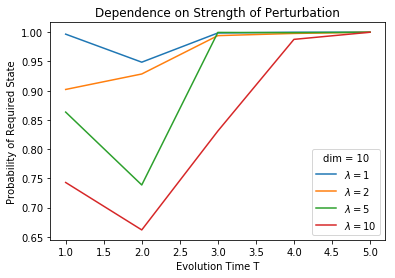

In [67]:
dim = 10
b = 0
lam = 0
p_max = 5

psi_i = state_n(dim, 0)

for i, value in enumerate([1, 2, 5,10]):
    
    lam = value
    e, v = np.linalg.eig(op_Hf(dim, b, lam))
    psi_f = v[:, np.argmin(e)]
    P_ar, probs = run_QAOA(p_max)
    plt.plot(P_ar, probs, label = r'$\lambda =$' + str(round(value,1)), alpha = 1)

plt.xlabel('Evolution Time T')
plt.ylabel('Probability of Required State')
plt.title('Dependence on Strength of Perturbation')
plt.legend(title = 'dim = 10')
#plt.savefig(fname = "qaoa_lam.png", dpi = 300)

### Other Failed Attempts

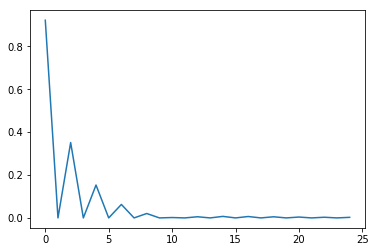

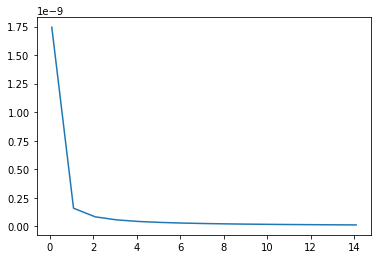

In [49]:
lam = 5
b = 0
dim = 25

T_range = []
prob = []

psi_i = state_n(dim, 0)

Hf = op_Hf(dim, b, lam)
eigval, eigvec  = np.linalg.eig(Hf)
psi_f = eigvec[:,np.argmin(eigval)]
plt.plot(np.abs(psi_f))
plt.show()

T_ar = np.arange(0.1,15,1)
for T in T_ar:
    
    time = np.linspace(0,T,1000)
    step = T/1000
    psi = psi_i + 1j*np.zeros(dim)
    for t in time:
        H_t = op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T)
        del_psi = -1j*np.dot(H_t,psi)*step
        psi += del_psi
        # print(np.dot(np.conj(psi),psi))
        psi = psi/np.linalg.norm(psi)
            
    overlap = np.dot(np.conjugate(psi_f),psi)

    T_range.append(T)
    prob.append(np.linalg.norm(overlap))
    
plt.plot(T_range, prob)
#plt.yscale('log')
#plt.ylim(-2, 2)
plt.show()

In [43]:
# T = 10
lam = 0.1
b = 0
time = np.arange(0,10,0.01)
dim = 40

T_range = []
prob1 = []
prob2 = []

psi_i = state_n(dim, 0)
H_t = 1j*np.zeros((dim,dim))

Hf = op_Hf(dim, b, lam)
eigval, eigvec  = np.linalg.eig(Hf)
psi_f = eigvec[np.argmin(eigval)]
print("psi_f",psi_f)

# T_ar = np.logspace(-50,-37,100)
T_ar = np.arange(0,1000,1)
for T in T_ar:
    
#     time = np.arange(0,T,0.0001)
#     for t in time:
#         H_t += (op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T))*0.1
    #print(np.real(H_t))
    
#     time = np.arange(0,T,0.01)
#     for t in time:
#         mat = (op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T))*0.1
#         if (t == 0):
#             H_t = mat
#         else:
#             H_t = np.dot(mat,H_t)
            
        
    #print(np.real(H_t))

    H_t_2 = op_Hi(dim)*(T/2) + op_Hf(dim, b, lam)*(T/2)
    #print(np.real(H_t_2))
    
    # psi_T1 = np.dot(expm(-1j*H_t),psi_i)
    psi_T2 = np.dot(expm(-1j*const_hbar*H_t_2),psi_i)
    #print("state time",psi_T2)
    #print(np.absolute(psi_T))
    
    # overlap1 = np.dot(psi_f,psi_T1)
    #print(overlap1)
    psi_T2 = psi_T2/np.linalg.norm(psi_T2)
    overlap2 = np.dot(np.conjugate(psi_f),psi_T2)
    
    #print("overlap",overlap2)
    #print(np.dot(np.conj(psi_T2), psi_T2))
    T_range.append(T)
    #prob1.append(np.linalg.norm(psi_T1))
    #prob2.append(np.linalg.norm(psi_T2))
    #prob1.append(np.dot(np.conj(overlap1),overlap1))
    prob2.append(np.linalg.norm(overlap2)**2)

psi_f [ 4.36610259e-06+0.j  1.87318835e-04+0.j  2.68652236e-03+0.j
  2.15394561e-16+0.j  1.95788608e-02+0.j  1.61837645e-16-0.j
  8.46894359e-02-0.j  2.20270476e-16+0.j  2.31871617e-01-0.j
  3.12525347e-16-0.j -1.89448751e-16+0.j  4.05135895e-01-0.j
  4.70293657e-16-0.j  4.22314478e-01+0.j -4.97309019e-05+0.j
 -2.10419584e-15+0.j  1.79800328e-01+0.j -3.24564030e-04+0.j
  1.27392885e-01+0.j  8.55701503e-03-0.j  1.44226124e-15-0.j
 -3.52308215e-02+0.j  2.50700398e-01+0.j -3.40655426e-01+0.j
  5.01523423e-01+0.j -1.31650494e-01+0.j -2.73372535e-01+0.j
  1.54367941e-01-0.j  2.28318576e-16-0.j  1.42707695e-16+0.j
  3.92831217e-17-0.j -1.32722645e-16+0.j  1.33049003e-17-0.j
 -1.85018824e-16+0.j  1.47299978e-16+0.j -3.71952373e-16+0.j
  9.13799829e-16-0.j  9.81834031e-17-0.j  5.61959285e-16+0.j
 -2.35320779e-16+0.j]


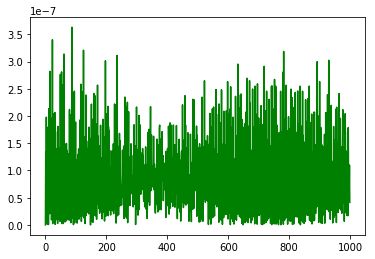

In [44]:
#plt.plot(T_range, prob1, color = 'b')
plt.plot(T_range, prob2, color = 'g')
#plt.xscale('log')
plt.show()

In [36]:
eigval, eigvec  = np.linalg.eig(Hf)
eigval

array([48.44674207+0.j,  0.5072562 +0.j, 37.85987546+0.j,  2.5908458 +0.j,
       47.52905502+0.j, 31.50675541+0.j,  4.77491312+0.j,  7.04832688+0.j,
       27.67056   +0.j,  9.40269231+0.j,  1.53564828+0.j, 24.91850178+0.j,
       11.83140079+0.j,  3.67109494+0.j, 36.89494242+0.j, 22.19510504+0.j,
       14.32908402+0.j, 19.5141654 +0.j,  5.90102667+0.j, 16.89127572+0.j,
       30.45004579+0.j,  8.21583781+0.j, 10.60811357+0.j, 26.42676103+0.j,
       13.07191784+0.j, 23.55880521+0.j, 20.84873702+0.j, 18.19535846+0.j,
       15.60236405+0.j, 16.97779189+0.j])

In [109]:
state_n(5, 0) + 1j*np.zeros(5)

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [ ]:
psi_i = [1,0,0,0,0]
psi_T = np.dot(expm(-1j*H_t),psi_i)
print(psi_T)
print(np.absolute(psi_T))

In [ ]:
mat = expm(-1j*H_t)
np.dot(np.transpose(np.conj(mat)),mat) - np.eye(5)

In [ ]:
np.absolute([3+4j])

In [ ]:
np.linalg.norm([3+4j, 4j])

In [ ]:
state_n(10,0)

In [ ]:
dim = 10
lam = 0.1
psi_f = psi_i + lam*(-np.sqrt(2)/8)*(3*state_n(dim, 2) + np.sqrt(3)*state_n(dim, 4))
np.dot(psi_f,psi_f)

#### Sanity Checks

In [ ]:
x = op_x(5)
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5)
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) 
vec1 = np.asarray([0,1,0,0,0])
vec2 = np.asarray([0,0,1,0,0])
(0.6)*(0.8)*(np.dot(vec1,np.dot(x,vec2)) + np.dot(vec2,np.dot(x,vec1)))

In [ ]:
x = op_x(5) - 3*np.eye(5) # subtracting 3*I
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) - 3 # element wise subtraction
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) - 3*np.eye(5) # subtracting 3*I
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) - 3 # element wise subtraction
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))